# 1D FDM - Electrostatics in Cylindrical Coordinates
In this notebook, the theory of the 1D finite difference method in cylinderical coordinates is explained and applied to three electrostatics examples involving coaxial cylinder configurations.

# Theory

## Electroquasistatics
Under quasi-static conditions, the coupling between the electric and magnetic field is neglected. For the electric field this leaves the following equations:
$$\left\{ \begin{array}{l}
    \nabla \times \mathbf{E} = 0 \implies \mathbf{E} = -\nabla V \\
    \nabla \cdot \mathbf{D} = \rho \\
    \mathbf{D} = \epsilon \mathbf{E}
\end{array} \right.$$

## Formulation in 1D Cylindrical Coordinates
Consider the geometry under investigation invariant in the $\phi$ and $z$ directions. Then the electrostatic equations given above can be written in terms of $r$ only.
$$\nabla \cdot \mathbf{D} = \frac{\partial}{\partial r} \left[ \epsilon(r) \frac{\partial V}{\partial r}\right] + \frac{\epsilon(r)}{r} \frac{\partial V}{\partial r} = -\rho(r)$$
In more generalized terms, $u(r) = V(r)$ is the unknown electric potential, $f(r) = -\rho(r)$ is the source function representing the charge density, and $c(r) = \epsilon(r)$ is a generalized diffusion coefficient, encoding the material properties: dielectric constant.
$$\frac{\partial}{\partial r} \left[ c(r) \frac{\partial u}{\partial r}\right] + \frac{c(r)}{r} \frac{\partial u}{\partial r} = f(r)$$

## Finite Difference Approximation
Discretizing this differential equation using the finite difference approximation, we obtain
$$\frac{1}{h^2}\left[ c_{i-0.5} u_{i-1} - (c_{i+0.5} + c_{i-0.5}) u_i + c_{i+0.5} u_{i+1} \right] + \frac{1}{2 h r} \left[ c_i u_{i+1} - c_i u_{i-1}\right] = f_i$$
The factor $1/r$ in the second term has been a source of debate. The whole equation can be multiplied by $r$ to eliminate this factor. However, it could be left like this under the proposition that the term is never actually evaluated in $r_1 = 0$, because of the boundary condition.

Let $A = B^T B$ be the one-dimensional Poisson matrix, where $B$ and $B^T$ can be interpreted as single derivatives.
The matrix equation becomes
$$(r B^T D B + E C) \mathbf{u} = \mathbf{f}$$
where $D$ and $E$ are diagonal matrices describing the diffusion coefficient $c(r)$ on the midpoints and nodes respectively.

# Import packages

In [43]:
using LinearAlgebra
using Interpolations
using Plots
using LaTeXStrings

# Example 1: Coaxial Cylinders
Consider a configuration consisting of coaxial cylinders with a cross-section as shown in the figure. The inner cylinder has a voltage applied to it, and the outer cylinder is grounded. There is a dielectric material between the cylinders.

![ex1_config](images/ex1_config.svg)

## Analytical Solution
The analytical solution in the case of a single dielectric material can easily be calculated from the Laplace equation.
$$\nabla^2 V = \frac{1}{r} \frac{\partial}{\partial r} \left[ r \frac{\partial V}{\partial r} \right] = 0 \implies V(r) = A \ln r + B$$
Applying the boundary conditions $V(r=a) = V_0$ and $V(r=b) = 0$, the analytical solution is found:
\begin{align*}
    V(r)   & = \frac{V_0}{\ln a/b} \ln r/b \\
    E_r(r) & = \frac{1}{r} \frac{V_0}{\ln a/b}
\end{align*}

## FDM Code

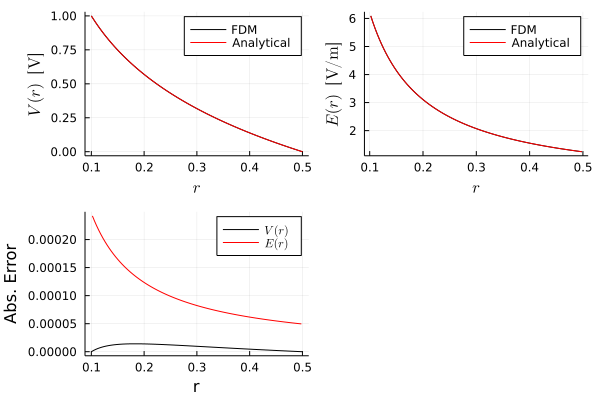

In [44]:
# Parameters
a = 0.1;  # Inner radius
b = 0.5;  # Outer radius

V0 = 1;   # Voltage of inner cylinder

eps0 = 8.85e-12;
eps1 = 2 * eps0;  # Permittivity of dielectric material

# Construct the 1D mesh
N = 100; Np1 = N+1; h = (b - a) / N; h2 = h*h; 
x = Vector(a : h : b); 
xmid = x[1:end-1] .+ h / 2; 

# Define source and material
f = zeros(Np1);

eps(x)  = eps1 .* ones(size(x));
D = eps(xmid);
E = eps(x);

# Construct A and B, and C matrices
#  A: Double derivative in x direction
#  B and BT: Single derivative in x direction (on xmid)
#  C: Single derivative in x direction (on x)
B = Float64[i==j ? (-1.)/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)
C = 1/(2*h) * Tridiagonal(ones(N), zeros(N+1), -ones(N));

A = x .* BT * Diagonal(D) * B + Diagonal(E) * C;

# Boundary conditions
A[1,1] = 1;          A[1,2] = 0;           f[1] = V0;    # Inner cylinder voltage
A[end,end-1] = 0;    A[end,end] = 1;       f[end] = 0;   # V = 0: Grounded outer cylinder

# Solve differential equation
u   = A \ f;
ux  = B * u;

# Analytical solution (only valid for a > 0)
u_a = V0 * log.(x / b) ./ log(a / b);
ux_a = -V0 ./ (xmid * log(b / a));


p1 = plot(x, u, color = :black, xlabel = L"r", ylabel = L"V(r)\ \ [\mathrm{V}]", label = "FDM");
p1 = plot!(x, u_a, color = :red, label = "Analytical")

p2 = plot(xmid, abs.(ux), color = :black, xlabel = L"r", ylabel = L"E(r)\ \ [\mathrm{V/m}]", label = "FDM");
p2 = plot!(xmid, abs.(ux_a), color = :red, label = "Analytical")

p3 = plot(x, abs.(u - u_a), color = :black, xlabel = "r", ylabel = "Abs. Error", label = L"V(r)")
p3 = plot!(xmid, abs.(ux - ux_a), color = :red, label = L"E(r)")

plot(p1, p2, p3)

# Example 2: Coaxial Cylinders II
Consider a configuration consisting of coaxial cylinders with a cross-section as shown in the figure. The inner cylinder has a voltage applied to it, and the outer cylinder is grounded. There are two dielectric materials with different dielectric constants between the cylinders.

![ex2_config](images/ex2_config.svg)

## Analytical Solution
For a coaxial cylinder configuration with different material layers $k = 1, \dots, n$ with radii $r_k$, the electric field strength in the radial direction is
$$E_{r,k} = \frac{V_0}{r} \frac{1}{\frac{\epsilon_k}{\epsilon_1} \ln\frac{r_2}{r_1} + \frac{\epsilon_k}{\epsilon_2} \ln\frac{r_3}{r_2} + \dots}$$

## FDM Code

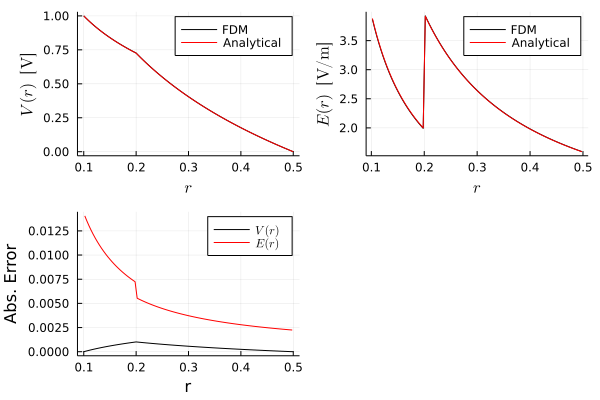

In [45]:
# Parameters
a = 0.1;  # Inner radius
c = 0.2;  # Radius of first material
b = 0.5;  # Outer radius

V0 = 1;   # Voltage of inner cylinder

eps0    = 8.85e-12;
eps_in  = 6 * eps0;  # Permittivity of inner material
eps_out = 3 * eps0;  # Permittivity of outer material

# Construct the 1D mesh
N = 100; Np1 = N+1; h = (b - a) / N; h2 = h*h; 
x = Vector(a : h : b); 
xmid = x[1:end-1] .+ h / 2; 

# Define source and material
f = zeros(Np1);

eps(x)  = eps_in .* (x .< c) + eps_out .* (x .>= c);
D = eps(xmid);
E = eps(x);

# Construct A and B, and C matrices
#  A: Double derivative in x direction
#  B and BT: Single derivative in x direction (on xmid)
#  C: Single derivative in x direction (on x)
B = Float64[i==j ? (-1.)/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)
C = 1/(2*h) * Tridiagonal(ones(N), zeros(N+1), -ones(N));

A = x .* BT * Diagonal(D) * B + Diagonal(E) * C;

# Boundary conditions
A[1,1] = 1;          A[1,2] = 0;           f[1] = V0;    # Inner cylinder voltage
A[end,end-1] = 0;    A[end,end] = 1;       f[end] = 0;   # V = 0: Grounded outer cylinder

# Solve differential equation
u   = A \ f;
ux  = B * u;

# Analytical solution (only valid for a > 0)
u_a = V0 .- V0 * log.(x/a) ./ (log(c/a) + eps_in/eps_out * log(b/c)) .* (x .< c) .- (V0 * log.(c/a) ./ (log(c/a) + eps_in/eps_out * log(b/c)) .+ V0 * log.(x/c) ./ (eps_out/eps_in * log(c/a) + log(b/c))) .* (x .>= c);
ux_a = -V0 ./ xmid ./ (log(c/a) + eps_in/eps_out * log(b/c)) .* (xmid .< c) + -V0 ./ xmid ./ (eps_out/eps_in * log(c/a) + log(b/c)) .* (xmid .>= c);


p1 = plot(x, u, color = :black, xlabel = L"r", ylabel = L"V(r)\ \ [\mathrm{V}]", label = "FDM");
p1 = plot!(x, u_a, color = :red, label = "Analytical")

p2 = plot(xmid, abs.(ux), color = :black, xlabel = L"r", ylabel = L"E(r)\ \ [\mathrm{V/m}]", label = "FDM");
p2 = plot!(xmid, abs.(ux_a), color = :red, label = "Analytical")

p3 = plot(x, abs.(u - u_a), color = :black, xlabel = "r", ylabel = "Abs. Error", label = L"V(r)")
p3 = plot!(xmid, abs.(ux - ux_a), color = :red, label = L"E(r)")

plot(p1, p2, p3)

# Example 3: Space Charge
Instead of restricting the domain of computation to the inner and outer radius of the cylinder, consider the domain from $0$ to $1$. By placing appropriate charge in space (i.e. at the location where the inner and outer radius are) the same graphs as above can be obtained. In this example, the configuration is identical to example 1.

![ex3_config](images/ex1_config.svg)

The capacitance of the coaxial cylinder configuration with a single dielectric material is
$$ C = \frac{2\pi\epsilon l}{\ln b/a} $$
Then for an applied voltage of $V_0 = 1\,\mathrm{V}$, we need to place the following charges
\begin{align*}
    \sigma(r = a) & = 34.55\,\mathrm{pC/m} \\ 
    \sigma(r = b) & = -34.55\,\mathrm{pC/m} \\
\end{align*}

## FDM Code

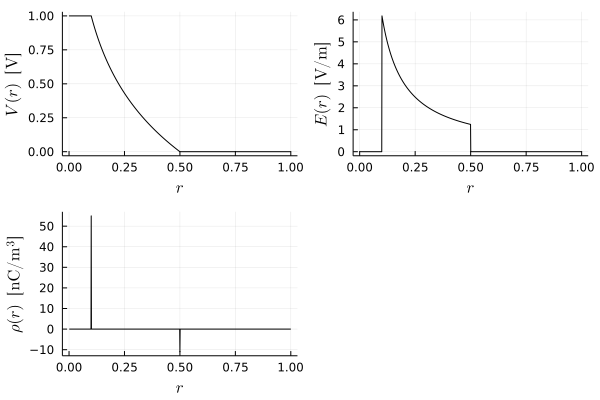

In [46]:
# Construct the 1D mesh
N = 1000; Np1 = N+1; h = 1 / N; h2 = h*h; 
x = Vector(0 : h : 1); 
xmid = x[1:end-1] .+ h / 2; 

# Define source and material
f = 3.455e-11 * (x .> 0.099) .* (x .< 0.101) - 3.455e-11 * (x .> 0.499) .* (x .< 0.501);

f = f ./ (2*pi*x * h); # Convert C/m to C/m^3
f = f .* x; # Multiply by x to eliminate division in DE

eps0 = 8.85e-12;
D = eps0 * ones(N);
E = eps0 * ones(Np1);

# Construct A and B matrices
B = Float64[i==j ? (-1.)/h : i==j-1 ? 1/h : 0 for i = 1:N, j=1:Np1]
BT = Transpose(B)
C = 1/(2*h) * Tridiagonal(ones(N), zeros(N+1), -ones(N));

A = x .* BT * Diagonal(D) * B + Diagonal(E) * C;

# Boundary conditions
A[1,1] = 1/h;        A[1,2] = -1/h;        f[1] = 0;     # Axisymmetry
A[end,end-1] = 0;    A[end,end] = 1;       f[end] = 0;   # V = 0  

# 
u   = A \ f;
ux  = B * u;

p1 = plot(x, u, color = :black, xlabel = L"r", ylabel = L"V(r)\ \ [\mathrm{V}]", legend = false);
p2 = plot(xmid, abs.(ux), color = :black, xlabel = L"r", ylabel = L"E(r)\ \ [\mathrm{V/m}]", legend = false);
p3 = plot(x, f ./ x * 1e9, color = :black, xlabel = L"r", ylabel = L"\rho(r)\ \ [\mathrm{nC/m^3}]", legend = false);

plot(p1, p2, p3)